In [69]:
#in this notebook, we will predict next frame (n+1) given previous two frames (n-1 and n)
#we will use horn schunck and lukas kanade algorithm to get the optical flows

## flowpy: -> to provide optical flow utilities
1. flow to image
2. wrap forward flow
3. warp backward flow

In [70]:
import flowpy

In [100]:
#libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import scipy.ndimage
import scipy.signal
import scipy.interpolate

#### parameters

In [118]:
N = 9
alph = 2
iterations = 250

### frames

In [119]:
first_frame_index = 7
second_frame_index = 8
third_frame_index = 9

In [120]:
first_frame_path = 'corridor/bt.00'+str(first_frame_index)+'.pgm'
second_frame_path = 'corridor/bt.00'+str(second_frame_index)+'.pgm'
third_frame_path = 'corridor/bt.00'+str(third_frame_index)+'.pgm'

In [121]:
#load all 3 frames
first_frame = cv2.imread(first_frame_path)
second_frame = cv2.imread(second_frame_path)
third_frame = cv2.imread(third_frame_path)


#make gray scale
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
second_frame = cv2.cvtColor(second_frame, cv2.COLOR_BGR2GRAY)
third_frame = cv2.cvtColor(third_frame, cv2.COLOR_BGR2GRAY)

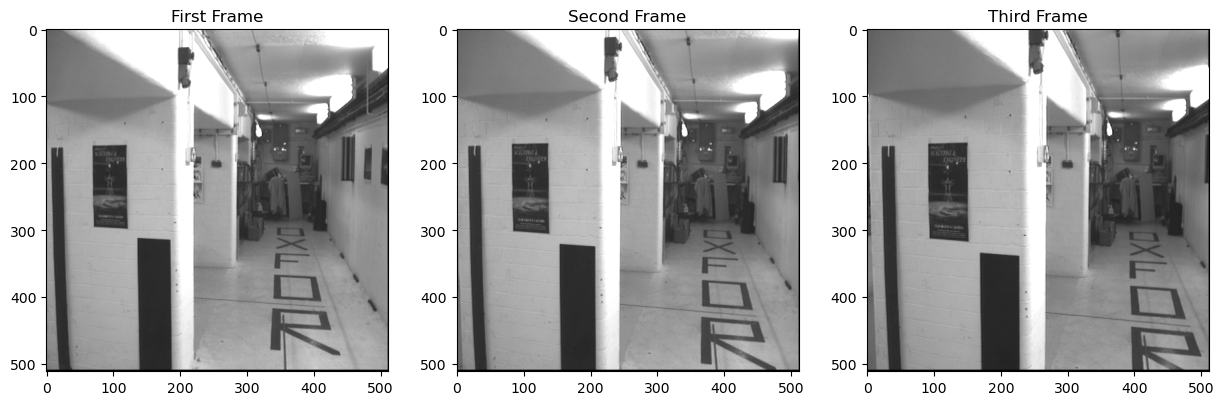

In [122]:
#show all 3 frames in a single plot, single row, 3 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(first_frame, cmap='gray')
#title: first frame
ax[0].set_title('First Frame')
ax[1].imshow(second_frame, cmap='gray')
#title: second frame
ax[1].set_title('Second Frame')
ax[2].imshow(third_frame, cmap='gray')
#title: third frame
ax[2].set_title('Third Frame')

#show the plot
plt.show()




# Horn and Schunck optical flow

In [123]:

def compute_gradients(firstImage, secondImage):
    """
    Compute gradients in x, y and t direction between images
    :param firstImage: First image
    :param secondImage: Second image
    :return: Gradients
    """

    firstImage = firstImage / 255
    secondImage = secondImage / 255

    # Kernels for finding gradients Ix, Iy, It
    kernel_x = np.array([[-1, 1]])
    kernel_y = np.array([[-1], [1]])
    kernel_t = np.array([[1]])



    Ix = scipy.ndimage.convolve(input=firstImage, weights=kernel_x, mode="nearest")
    Iy = scipy.ndimage.convolve(input=firstImage, weights=kernel_y, mode="nearest")
    It = scipy.ndimage.convolve(input=secondImage, weights=kernel_t, mode="nearest") + scipy.ndimage.convolve(
        input=firstImage, weights=-kernel_t, mode="nearest"
    )

    I = [Ix, Iy, It]

    return I

In [124]:

def horn_schunk(firstImage, secondImage, lambada = alph, num_iter= iterations, plot_flow = False):
    """
    Horn Schunk Optical flow estimation between firstImage and secondImage
    :param firstImage: First image
    :param secondImage: Second Image
    :param lambada: Regularization parameter
    :param num_iter: Number of iterations of optimization

    :return: Optical flow, Gradients
    """

    u = np.zeros([firstImage.shape[0], firstImage.shape[1]])
    v = np.zeros([firstImage.shape[0], firstImage.shape[1]])

    [Ix, Iy, It] = compute_gradients(firstImage, secondImage)

    # Optical flow averaging kernel
    kernel = np.array([[0, 1 / 4, 0], [1 / 4, 0, 1 / 4], [0, 1 / 4, 0]], dtype=np.float32)

    for _ in range(num_iter):
        u_avg = scipy.ndimage.convolve(input=u, weights=kernel, mode="nearest")
        v_avg = scipy.ndimage.convolve(input=v, weights=kernel, mode="nearest")

        grad = (Ix * u_avg + Iy * v_avg + It) / (lambada ** 2 + Ix ** 2 + Iy ** 2)

        u = u_avg - lambada * Ix * grad
        v = v_avg - lambada * Iy * grad

   

    flow = np.stack((u, v), axis=2)
    if plot_flow:
        fig, ax = plt.subplots()
        ax.imshow(flowpy.flow_to_rgb(flow))
        plt.show()
  

    return flow

## Lucas Kanade

In [125]:
def lucas_kanade(firstImage, secondImage, N= N,  tau=1e-3, plot_flow = False):
    """
    Lucas Kanade Optical flow estimation between firstImage and secondImage
    :param firstImage: First image
    :param secondImage: Second Image
    :param N: Block size N x N
    :param tau: Threshold parameter
    :return: Optical flow, Gradients
    """

    firstImage = firstImage / 255
    secondImage = secondImage / 255
    image_shape = firstImage.shape
    half_window_size = N // 2

    # Kernels for finding gradients Ix, Iy, It
    kernel_x = np.array([[-1, 1]])
    kernel_y = np.array([[-1], [1]])
    kernel_t = np.array([[1]])

    Ix = scipy.ndimage.convolve(input=firstImage, weights=kernel_x, mode="nearest")
    Iy = scipy.ndimage.convolve(input=firstImage, weights=kernel_y, mode="nearest")
    It = scipy.ndimage.convolve(input=secondImage, weights=kernel_t, mode="nearest") + scipy.ndimage.convolve(
        input=firstImage, weights=-kernel_t, mode="nearest"
    )

    u = np.zeros(image_shape)
    v = np.zeros(image_shape)

    # Find Lucas Kanade OF for a block N x N with least squares solution
    for row_ind in range(half_window_size, image_shape[0] - half_window_size):
        for col_ind in range(half_window_size, image_shape[1] - half_window_size):
            Ix_windowed = Ix[
                row_ind - half_window_size : row_ind + half_window_size + 1,
                col_ind - half_window_size : col_ind + half_window_size + 1,
            ].flatten()
            Iy_windowed = Iy[
                row_ind - half_window_size : row_ind + half_window_size + 1,
                col_ind - half_window_size : col_ind + half_window_size + 1,
            ].flatten()
            It_windowed = It[
                row_ind - half_window_size : row_ind + half_window_size + 1,
                col_ind - half_window_size : col_ind + half_window_size + 1,
            ].flatten()

            A = np.asarray([Ix_windowed, Iy_windowed]).reshape(-1, 2)
            b = np.asarray(It_windowed)

            A_transpose_A = np.transpose(A) @ A

            A_transpose_A_eig_vals, _ = np.linalg.eig(A_transpose_A)
            A_transpose_A_min_eig_val = np.min(A_transpose_A_eig_vals)

            # Noise thresholding
            if A_transpose_A_min_eig_val < tau:
                continue

            A_transpose_A_PINV = np.linalg.pinv(A_transpose_A)
            w = A_transpose_A_PINV @ np.transpose(A) @ b

            u[row_ind, col_ind], v[row_ind, col_ind] = w


    flow = np.stack((u, v), axis=2)
    if plot_flow:
        fig, ax = plt.subplots()
        ax.imshow(flowpy.flow_to_rgb(flow))
        plt.show()


    return flow, I

## Warping images (backward):

In [126]:
#write a function to make flow to the format accepted by flowpy
def flow_to_flowpy_format(flow):
    #check if flow is numpy array or not , if not then convert it to numpy array
    if not isinstance(flow, np.ndarray):
        flow = np.array(flow)
    #now we will check if the shape of flow is (height, width, 2) and dtype float64, if not then we will convert it
    if flow.shape != (flow.shape[0], flow.shape[1], 2) or flow.dtype != np.float64:
        flow = flow.astype(np.float64)
        #check which dimension is 2 , and we permute the dimension 2 to the last dimension
        if flow.shape[0] == 2:
            flow = np.transpose(flow, (1, 2, 0))
        elif flow.shape[1] == 2:
            flow = np.transpose(flow, (0, 2, 1))
        elif flow.shape[2] != 2:
            raise ValueError("Flow shape must be (height, width, 2)")

    return flow


## Warping images (backward):

In [127]:
# We know the flow (first_image -> second_image),we will backward warp the second_image back to first_image.
#we will define a function to use th python lib : flowpy.backward_warp(second_image, flow)
#the flow should be a 3D array with shape (height, width, 2) and dtype float64
def warp_flow_backward(second_image, flow):
    """
    Backward warp a given image using the given flow
    :param flow: Flow
    :param image: Image
    :return: Backward warped image
    """
    #check if image is numpy array or not , if not then convert it to numpy array
    if not isinstance(second_image, np.ndarray):
        image = np.array(second_image)

    
    return flowpy.backward_warp(second_image, flow)

## Warping images (forward):

In [128]:
#Forward warp is quite more complex. It relies on a k-nearest neighbor search instead of direct bi-linear interpolation.
#we will use library flowpy.forward_warp(first_image, flow)
def warp_flow_forward(first_image, flow):
    """
    Forward warp a given image using the given flow
    :param flow: Flow
    :param image: Image
    :return: Forward warped image
    """
    #check if image is numpy array or not , if not then convert it to numpy array
    if not isinstance(first_image, np.ndarray):
        image = np.array(first_image)


    return flowpy.forward_warp(first_image, flow)
   

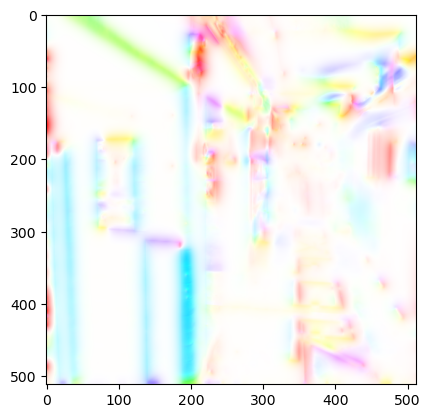

In [129]:
#call horn schunck function
flow_hs  = horn_schunk(first_frame, second_frame, plot_flow=True)


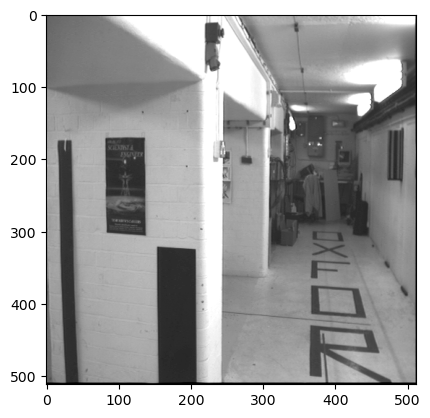

In [132]:
#warped image by backward warping
warped_image = warp_flow_backward(second_frame, flow_hs)
fig, ax = plt.subplots()
ax.imshow(warped_image, cmap='gray')
plt.show()


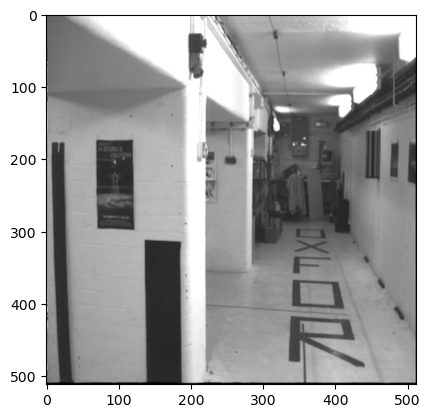

In [133]:
#test forward warping
warped_image = warp_flow_forward(first_frame, flow_hs)
fig, ax = plt.subplots()
ax.imshow(warped_image, cmap='gray')
plt.show()



In [134]:
#defina a function to plot the first image , second image , the flow image and the warped image
def plot_warping(first_image, second_image, flow, warped_image, warp_mode = "backward"):
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        axs[0, 0].imshow(first_image, cmap="gray")
        axs[0, 0].set_title("First Image")
        axs[0, 1].imshow(second_image, cmap="gray")
        axs[0, 1].set_title("Second Image")
        axs[1, 0].imshow(flowpy.flow_to_rgb(flow))
        axs[1, 0].set_title("Flow")
        axs[1, 1].imshow(warped_image, cmap="gray")
        axs[1, 1].set_title("Warped " + warp_mode+ " Image")
        plt.show()

In [135]:
#wrapper for the above function
def plot_warping_wrapper(first_image, second_image, method="hs",  warp_mode = "backward"):
        #get optical flow as per the method
        if method == "hs":
                flow= horn_schunk(first_image, second_image)
        elif method == "lk":
                flow = lucas_kanade(first_image, second_image)
        #else error
        else:
                raise ValueError("method should be either hs or lk")

        #check if warp_mode is backward or forward
        if warp_mode == "backward":
                warped_image = warp_flow_backward(second_image, flow)
        elif warp_mode == "forward":
                warped_image = warp_flow_forward(first_image, flow)
        #else error
        else:
                raise ValueError("warp_mode should be either backward or forward")

        plot_warping(first_image, second_image, flow, warped_image, warp_mode)

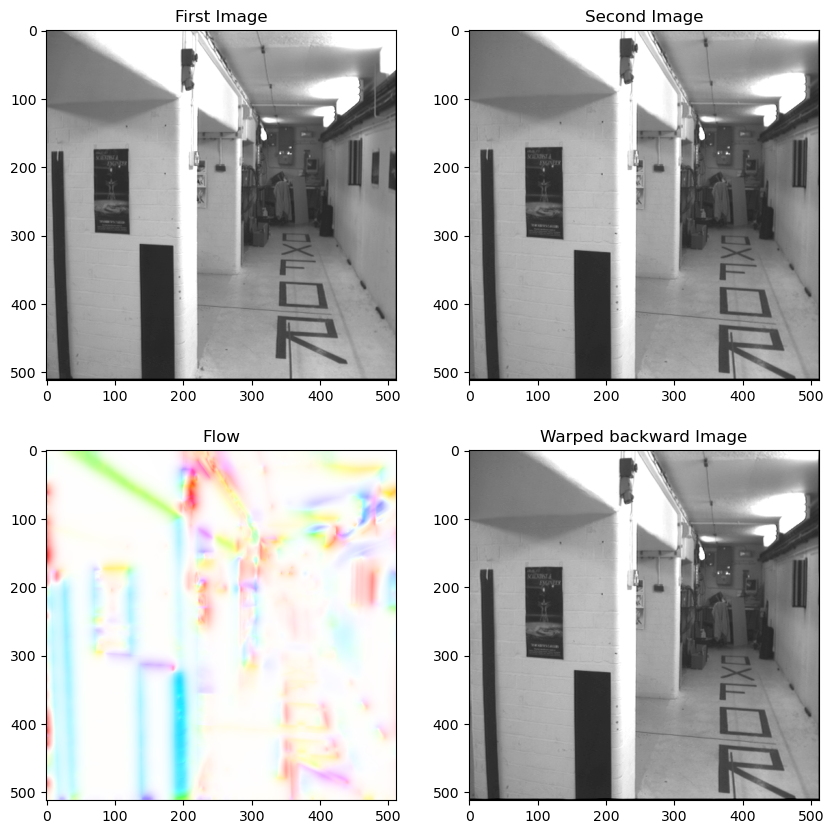

In [136]:
#call the above function
plot_warping_wrapper(first_frame, second_frame, method="hs", warp_mode="backward")

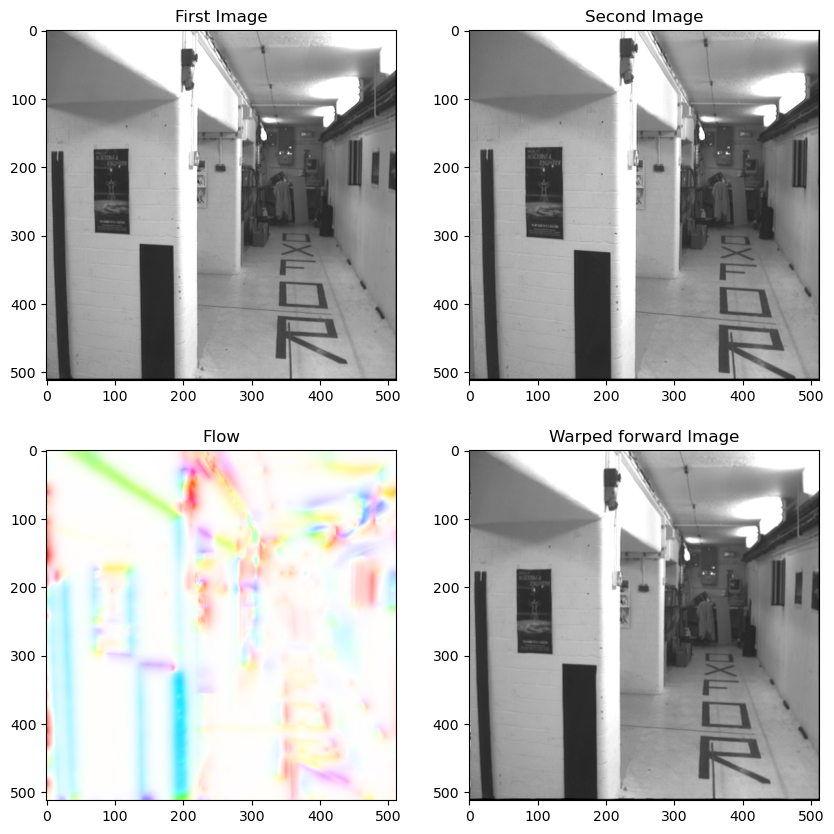

In [137]:
#call the above function forward
plot_warping_wrapper(first_frame, second_frame, method="hs", warp_mode="forward")


## predictioned frame

In [138]:
#we will write a code for next frame prediction given previous 2 frames
#the strategy would be: 
#1. get the forward flow : first_frame -> second_frame
#2. get the backward flow : first_frame <- second_frame
#3.  Predict Next Frame Forward: WARP FORWARD= second frame + forward flow (->) = Third Frame
#4.  Predict Next Frame Backward: WARP BACKWARD= second frame + backward flow (<-) = Third Frame
#5.  Predict Next Frame Average: AVERAGE = (WARP FORWARD + WARP BACKWARD)/2 = Third Frame

#we will define a function to do the above
def predict_next_frame(first_frame, second_frame, optical_flow="hs"):
    assert optical_flow in ["hs", "lk"], "optical_flow should be either hs or lk"
    #get the forward flow
    if optical_flow == "hs":
        flow_n_minus_1_to_n = horn_schunk(first_frame, second_frame)
    elif optical_flow == "lk":
        flow_n_minus_1_to_n = lucas_kanade(first_frame, second_frame)

    #get the backward flow
    if optical_flow == "hs":
        flow_n_to_n_minus_1 = horn_schunk(second_frame, first_frame)
    elif optical_flow == "lk":
        flow_n_to_n_minus_1 = lucas_kanade(second_frame, first_frame)

    #get the forward warped image
    forward_warped_image = warp_flow_forward(second_frame, flow_n_minus_1_to_n)

    #get the backward warped image
    backward_warped_image = warp_flow_backward(second_frame, flow_n_to_n_minus_1)

    #get the frame interpolated averaging, we can't just average the two warped images as the image quality will be bad
    #we need smoothed interpolated averaging of the two warped images

    #return the predicted next frame
    return average_warped_image


In [139]:
#call the above function
predicted_next_frame = predict_next_frame(first_frame, second_frame, optical_flow="hs")


In [140]:
#we write a function to take in first frame, second frame and plot first frame, second frame, predicted next frame
def plot_prediction(first_frame, second_frame, optical_flow="hs"):
    predicted_next_frame = predict_next_frame(first_frame, second_frame, optical_flow=optical_flow)
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(first_frame, cmap="gray")
    axs[0].set_title("First Frame")
    axs[1].imshow(second_frame, cmap="gray")
    axs[1].set_title("Second Frame")
    axs[2].imshow(predicted_next_frame, cmap="gray")
    axs[2].set_title("Predicted Next Frame")
    plt.show()

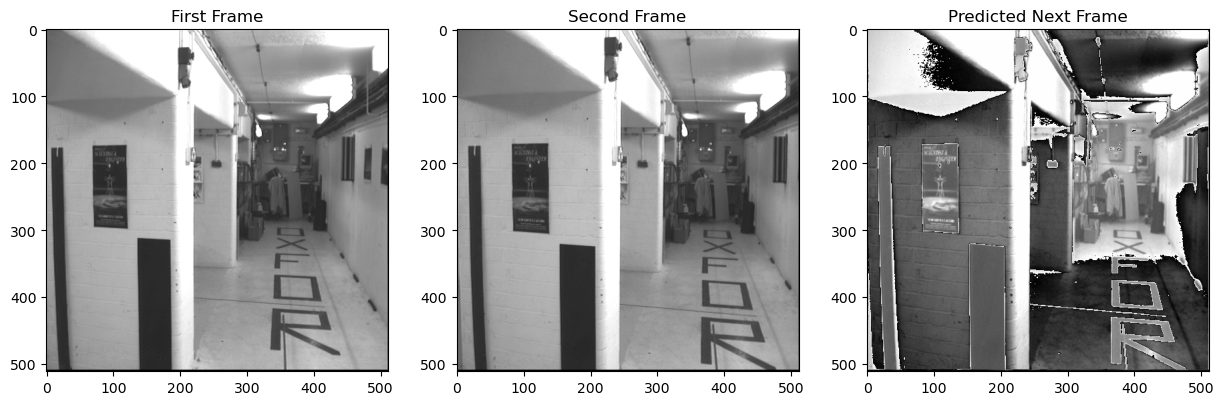

In [141]:
#plot the above
plot_prediction(first_frame, second_frame, optical_flow="hs")

## Next frame prediction taking care of occlusions


In [142]:
def outside_in_fill(image):
    """
    :param image: Image matrix to be filled
    :return: output
    """

    rows, cols = image.shape[:2]

    col_start = 0
    col_end = cols
    row_start = 0
    row_end = rows
    lastValid = np.full([2], np.nan)
    while col_start < col_end or row_start < row_end:
        for c in range(col_start, col_end):
            if not np.isnan(image[row_start, c, 0]):
                lastValid = image[row_start, c, :]
            else:
                image[row_start, c, :] = lastValid

        for r in range(row_start, row_end):
            if not np.isnan(image[r, col_end - 1, 0]):
                lastValid = image[r, col_end - 1, :]
            else:
                image[r, col_end - 1, :] = lastValid

        for c in reversed(range(col_start, col_end)):
            if not np.isnan(image[row_end - 1, c, 0]):
                lastValid = image[row_end - 1, c, :]
            else:
                image[row_end - 1, c, :] = lastValid

        for r in reversed(range(row_start, row_end)):
            if not np.isnan(image[r, col_start, 0]):
                lastValid = image[r, col_start, :]
            else:
                image[r, col_start, :] = lastValid

        if col_start < col_end:
            col_start = col_start + 1
            col_end = col_end - 1

        if row_start < row_end:
            row_start = row_start + 1
            row_end = row_end - 1

    output = image

    return output

In [164]:
def predict_next_frame_interpolate(first_image, second_image, forward_flow,backward_flow, optical_flow="hs"):
    predicted_next_frame = predict_next_frame(first_frame, second_frame, optical_flow="hs")

    height, width = first_image.shape

    af  = forward_flow[:,:,0]
    bf  = forward_flow[:,:,1]

    ab  = backward_flow[:,:,0]
    bb  = backward_flow[:,:,1]

    ut = np.full([af.shape[0], af.shape[1], 2], np.nan)

    # Occlusion detection
    occ_detect = True
    if occ_detect:
        similarity = np.full([height, width], np.inf)

    # get  optical flows
    xx = np.broadcast_to(np.arange(width), (height, width))
    yy = np.broadcast_to(np.arange(height)[:, None], (height, width))

    xt = np.round(xx +   af)
    yt = np.round(yy +   bf)

    #occlusion detection - flows

    for i in range(height):
        for j in range(width):
            i_ind_image = int(yt[i, j])
            j_ind_image = int(xt[i, j])

            if i_ind_image >= 0 and i_ind_image < height and j_ind_image >= 0 and j_ind_image < width:
                if occ_detect:
                    e = np.square(int(second_image[i_ind_image, j_ind_image]) - int(first_image[i, j]))
                    s = np.sum(e)
                    #print(e)
                    if s < similarity[i_ind_image, j_ind_image]:
                        ut[i_ind_image, j_ind_image, 0] = af[i, j]
                        ut[i_ind_image, j_ind_image, 1] = bf[i, j]
                        similarity[i_ind_image, j_ind_image] = s
                else:
                    ut[i_ind_image, j_ind_image, 0] = af[i, j]
                    ut[i_ind_image, j_ind_image, 1] = bf[i, j]

    uti = outside_in_fill(ut)

    # Occlusion masks
    occlusion_first = np.zeros_like(first_image)
    occlusion_second = np.zeros_like(second_image)
    #occlusion masks - forward flow--------------------------------
    occlusion_x1 = np.round(xx + af).astype(np.int)
    occlusion_y1 = np.round(yy + bf).astype(np.int)

    occlusion_x1 = np.clip(occlusion_x1, 0, height - 1)
    occlusion_y1 = np.clip(occlusion_y1, 0, width - 1)

    for i in range(occlusion_first.shape[0]):
        for j in range(occlusion_first.shape[1]):
            if np.abs(af[i, j] + ab[occlusion_x1[i, j], occlusion_y1[i, j]]) > 0.5:
                occlusion_first[i, j] = 1

            if np.abs(bf[i, j] + bb[occlusion_x1[i, j], occlusion_y1[i, j]]) > 0.5:
                occlusion_first[i, j] = 1
    #occlusion masks - backward flow--------------------------------
    occlusion_x1 = np.round(xx + ab).astype(np.int)
    occlusion_y1 = np.round(yy + bb).astype(np.int)

    occlusion_x1 = np.clip(occlusion_x1, 0, height - 1)
    occlusion_y1 = np.clip(occlusion_y1, 0, width - 1)

    for i in range(occlusion_second.shape[0]):
        for j in range(occlusion_second.shape[1]):
            if np.abs(ab[i, j] + af[occlusion_x1[i, j], occlusion_y1[i, j]]) > 0.5:
                occlusion_second[i, j] = 1

            if np.abs(bb[i, j] + bf[occlusion_x1[i, j], occlusion_y1[i, j]]) > 0.5:
                occlusion_second[i, j] = 1

    #convert occlusion_second to backward  warp
    occlusion_second = flowpy.backward_warp(occlusion_second, backward_flow)    #this makes it w.r.t n+1 frame

    # Intermediate image indices
    first_image_for_x = xx -   uti[:, :, 0]
    first_image_for_y = yy -   uti[:, :, 1]

    xt0 = np.clip(first_image_for_x, 0, height - 1)
    yt0 = np.clip(first_image_for_y, 0, width - 1)


    # Interpolate the images according to occlusion masks
    It = np.zeros(first_image.shape)
    image1_interp = scipy.interpolate.RectBivariateSpline(np.arange(width), np.arange(height), second_image.T)


    for i in range(It.shape[0]):
        for j in range(It.shape[1]):
            if not (occlusion_first[i, j] or occlusion_second[i, j]) or (
                    occlusion_first[i, j] and occlusion_second[i, j] 

            ):
                It[i, j] = image1_interp(xt0[i, j], yt0[i, j])
            else:
                
                It[i, j] = predicted_next_frame[i, j]

    It = It.astype(np.int)

    return It

In [165]:
#test the function
forward_flow_hs = horn_schunk( first_frame, second_frame)
backward_flow_hs = horn_schunk( second_frame, first_frame)
predicted_interpolation = predict_next_frame_interpolate(first_frame, second_frame , forward_flow=forward_flow_hs, backward_flow=backward_flow_hs)

/tmp/ipykernel_2499215/261639324.py:52: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  occlusion_x1 = np.round(xx + af).astype(np.int)
/tmp/ipykernel_2499215/261639324.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

<class 'numpy.ndarray'>
(512, 512)


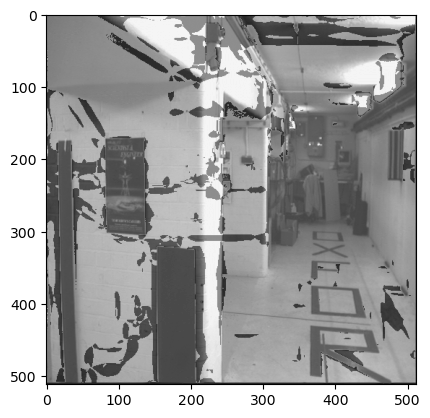

In [166]:
#type of predicted_interpolation
print(type(predicted_interpolation))
#shape
print(predicted_interpolation.shape)
#plot the predicted frame
plt.imshow(predicted_interpolation, cmap='gray')
plt.show()